<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using Xgboost</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [Github: xgboost](https://github.com/dmlc/xgboost)
- [github: fmfn/BayesianOptimization](https://github.com/fmfn/BayesianOptimization)
- [official basic tour](https://github.com/fmfn/BayesianOptimization/blob/master/examples/basic-tour.ipynb)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

## Colab

In [2]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO
    !git clone https://github.com/thuijskens/scikit-hyperband.git
    sys.path.append('scikit-hyperband/hyperband')

    # update modules
    !pip uninstall xgboost
    !pip install -U xgboost

    print('Environment: Google Colab')

In [3]:
sys.path.append('/Users/poudel/Dropbox/a00_Resources/hyperband/')
from hyperband_search import HyperbandSearchCV

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
import joblib
import plotly_express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
import sklearn.metrics as skmetrics
import warnings
from datetime import datetime
from functools import partial
from pprint import pprint as pp
from tqdm import tqdm
import xgboost as xgb

# settings
sns.set()
SEED = 100
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

%matplotlib inline
%load_ext watermark
%watermark -iv

seaborn        0.11.0
plotly_express 0.4.1
numpy          1.19.4
json           2.0.9
pandas         1.1.4
xgboost        1.2.0
autopep8       1.5.2
joblib         0.17.0



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [5]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [6]:
def model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=True):
    import sklearn.metrics as skmetrics
    import scikitplot.metrics as skpmetrics
    import os

    acc       = skmetrics.accuracy_score(ytest,ypreds)
    precision = skmetrics.precision_score(ytest,ypreds)
    recall    = skmetrics.recall_score(ytest,ypreds)
    f1        = skmetrics.f1_score(ytest,ypreds)
    auc       = skmetrics.roc_auc_score(ytest,ypreds)

    print(skmetrics.classification_report(ytest,ypreds))
    print(skmetrics.confusion_matrix(ytest,ypreds))

    df_res = pd.DataFrame({'Accuracy':[acc],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1-score': [f1],
                          'AUC': [auc]},index=[model_name])

    display(df_res.style.format("{:.4f}"))
    if not os.path.isdir('../outputs'):
        os.makedirs('../outputs')
    o = '.' if ENV_COLAB else '../outputs/'
    df_res.to_csv(o+f'model_{model_name}.csv',index=True)

    skpmetrics.plot_precision_recall(ytest,yprobs2d) # more focus on minority
    skpmetrics.plot_roc_curve(ytest,yprobs2d) # equal focus on both groups
    skpmetrics.plot_confusion_matrix(ytest,ypreds)

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [7]:
path_data_train = '../data/raw/train.csv'
path_data_test = '../data/raw/test.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/train.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/test.csv'

In [8]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 21)
(1409, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1621-YNCJH,Female,0,Yes,No,36,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,Yes,Two year,Yes,Credit card (automatic),106.05,3834.4,No
1,7143-BQIBA,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,Yes,Yes,No,Month-to-month,No,Bank transfer (automatic),62.25,612.95,No
5632,0862-PRCBS,Female,0,Yes,Yes,68,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),103.75,7039.45,No
5633,4656-CAURT,Male,0,No,No,69,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.95,1713.1,No


In [9]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [10]:
sys.path.append('../src')
from util import clean_data

In [11]:
index_name = 'customerID'

df_train = clean_data(df_train)
df_test  = clean_data(df_test)


ser_ytrain = df_train.pop(target_name).map({'No':0,'Yes':1})
ser_ytest = df_test.pop(target_name).map({'No':0,'Yes':1})

ser_train_ids = df_train.pop(index_name)
ser_ytest_ids = df_test.pop(index_name)

ytrain_full = np.array(ser_ytrain).ravel()
ytest = np.array(ser_ytest).ravel()

df_Xtest = df_test

In [12]:
df_train.head()

,tenure,MonthlyCharges,TotalCharges,Contract_TotalCharges_mean,Contract_TotalCharges_mean_diff,PaymentMethod_MonthlyCharges_mean,PaymentMethod_MonthlyCharges_mean_diff,MultipleLines_Ordinal,SeniorCitizen_Not_SenCit,SeniorCitizen_SeniorCitizen,Partner_No_Partner,Partner_Partner,Dependents_Dependents,Dependents_No_Dependents,PaperlessBilling_No_PaperlessBill,PaperlessBilling_PaperlessBill,PhoneService_No_PhoneService,PhoneService_PhoneService,OnlineSecurity_No internet service,OnlineSecurity_No_OnlineSecurity,OnlineSecurity_OnlineSecurity,OnlineBackup_No internet service,OnlineBackup_No_OnlineBackup,OnlineBackup_OnlineBackup,DeviceProtection_DeviceProtection,DeviceProtection_No internet service,DeviceProtection_No_DeviceProtection,TechSupport_No internet service,TechSupport_No_TechSupport,TechSupport_TechSupport,StreamingTV_No internet service,StreamingTV_No_StreamingTV,StreamingTV_StreamingTV,StreamingMovies_No internet service,StreamingMovies_No_StreamingMov,StreamingMovies_StreamingMov,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Dependents_No_Partner_Dependents,Partner_Dependents_No_Partner_No_Dependents,Partner_Dependents_Partner_Dependents,Partner_Dependents_Partner_No_Dependents,SeniorCitizen_Dependents_Not_SenCit_Dependents,SeniorCitizen_Dependents_Not_SenCit_No_Dependents,SeniorCitizen_Dependents_SeniorCitizen_Dependents,SeniorCitizen_Dependents_SeniorCitizen_No_Dependents,SeniorCitizen_Partner_Not_SenCit_No_Partner,SeniorCitizen_Partner_Not_SenCit_Partner,SeniorCitizen_Partner_SeniorCitizen_No_Partner,SeniorCitizen_Partner_SeniorCitizen_Partner,SeniorCitizen_Contract_Not_SenCit_Month-to-month,SeniorCitizen_Contract_Not_SenCit_One year,SeniorCitizen_Contract_Not_SenCit_Two year,SeniorCitizen_Contract_SeniorCitizen_Month-to-month,SeniorCitizen_Contract_SeniorCitizen_One year,SeniorCitizen_Contract_SeniorCitizen_Two year,SeniorCitizen_TechSupport_Not_SenCit_No internet service,SeniorCitizen_TechSupport_Not_SenCit_No_TechSupport,SeniorCitizen_TechSupport_Not_SenCit_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_No internet service,SeniorCitizen_TechSupport_SeniorCitizen_No_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_TechSupport,SeniorCitizen_PaymentMethod_Not_SenCit_Bank transfer (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Credit card (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Electronic check,SeniorCitizen_PaymentMethod_Not_SenCit_Mailed check,SeniorCitizen_PaymentMethod_SeniorCitizen_Bank transfer (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Credit card (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Electronic check,SeniorCitizen_PaymentMethod_SeniorCitizen_Mailed check
0,36,106.05,3834.40,3683.643192,150.756808,65.801934,40.248066,2,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,10,62.25,612.95,1370.923131,-757.973131,67.564819,-5.314819,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,25,19.15,477.60,1370.923131,-893.323131,43.792328,-24.642328,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7,20.00,137.60,1370.923131,-1233.323131,67.564819,-47.564819,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,24,20.30,459.95,1370.923131,-910.973131,43.792328,-23.492328,1,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [13]:
print(df_train.sum().sum(), df_test.sum().sum(),
      df_train.isna().sum().sum(), df_test.isna().sum().sum())

df_train.head()

26621171.299999997 6767495.3 0 0


,tenure,MonthlyCharges,TotalCharges,Contract_TotalCharges_mean,Contract_TotalCharges_mean_diff,PaymentMethod_MonthlyCharges_mean,PaymentMethod_MonthlyCharges_mean_diff,MultipleLines_Ordinal,SeniorCitizen_Not_SenCit,SeniorCitizen_SeniorCitizen,Partner_No_Partner,Partner_Partner,Dependents_Dependents,Dependents_No_Dependents,PaperlessBilling_No_PaperlessBill,PaperlessBilling_PaperlessBill,PhoneService_No_PhoneService,PhoneService_PhoneService,OnlineSecurity_No internet service,OnlineSecurity_No_OnlineSecurity,OnlineSecurity_OnlineSecurity,OnlineBackup_No internet service,OnlineBackup_No_OnlineBackup,OnlineBackup_OnlineBackup,DeviceProtection_DeviceProtection,DeviceProtection_No internet service,DeviceProtection_No_DeviceProtection,TechSupport_No internet service,TechSupport_No_TechSupport,TechSupport_TechSupport,StreamingTV_No internet service,StreamingTV_No_StreamingTV,StreamingTV_StreamingTV,StreamingMovies_No internet service,StreamingMovies_No_StreamingMov,StreamingMovies_StreamingMov,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Dependents_No_Partner_Dependents,Partner_Dependents_No_Partner_No_Dependents,Partner_Dependents_Partner_Dependents,Partner_Dependents_Partner_No_Dependents,SeniorCitizen_Dependents_Not_SenCit_Dependents,SeniorCitizen_Dependents_Not_SenCit_No_Dependents,SeniorCitizen_Dependents_SeniorCitizen_Dependents,SeniorCitizen_Dependents_SeniorCitizen_No_Dependents,SeniorCitizen_Partner_Not_SenCit_No_Partner,SeniorCitizen_Partner_Not_SenCit_Partner,SeniorCitizen_Partner_SeniorCitizen_No_Partner,SeniorCitizen_Partner_SeniorCitizen_Partner,SeniorCitizen_Contract_Not_SenCit_Month-to-month,SeniorCitizen_Contract_Not_SenCit_One year,SeniorCitizen_Contract_Not_SenCit_Two year,SeniorCitizen_Contract_SeniorCitizen_Month-to-month,SeniorCitizen_Contract_SeniorCitizen_One year,SeniorCitizen_Contract_SeniorCitizen_Two year,SeniorCitizen_TechSupport_Not_SenCit_No internet service,SeniorCitizen_TechSupport_Not_SenCit_No_TechSupport,SeniorCitizen_TechSupport_Not_SenCit_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_No internet service,SeniorCitizen_TechSupport_SeniorCitizen_No_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_TechSupport,SeniorCitizen_PaymentMethod_Not_SenCit_Bank transfer (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Credit card (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Electronic check,SeniorCitizen_PaymentMethod_Not_SenCit_Mailed check,SeniorCitizen_PaymentMethod_SeniorCitizen_Bank transfer (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Credit card (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Electronic check,SeniorCitizen_PaymentMethod_SeniorCitizen_Mailed check
0,36,106.05,3834.40,3683.643192,150.756808,65.801934,40.248066,2,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,10,62.25,612.95,1370.923131,-757.973131,67.564819,-5.314819,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,25,19.15,477.60,1370.923131,-893.323131,43.792328,-24.642328,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7,20.00,137.60,1370.923131,-1233.323131,67.564819,-47.564819,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,24,20.30,459.95,1370.923131,-910.973131,43.792328,-23.492328,1,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [14]:
ser_ytrain.head(2)

0    0
1    0
Name: Churn, dtype: int64

<a id="" ></a>

<h1>  Train Validation Split</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [15]:
from sklearn.model_selection import train_test_split

df_Xtrain_full = df_train.copy()
ser_ytrain_full = ser_ytrain.copy()

df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = train_test_split(
    df_Xtrain_full, ser_ytrain_full,
    test_size=0.2, random_state=SEED, stratify=ser_ytrain_full)

ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()

In [16]:
dtrain = xgb.DMatrix(df_train, label=ytrain)
dtest = xgb.DMatrix(df_test)

<a id="" ></a>

<h1>  Modelling: Xgboost </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [17]:
from sklearn.metrics import matthews_corrcoef

def profit(y_true, y_pred):
    tn, fp, fn, tp = skmetrics.confusion_matrix(y_true,y_pred).ravel()
    loss = 400*tp - 200*fn - 100*fp
    return loss

def metricProfit(preds,dtrain):
    labels = dtrain.get_label()
    preds = [1 if i>0.5 else 0 for i in preds]
    return 'Profit',profit(labels,preds)

In [18]:
import xgboost as xgb

params = {
    'learning_rate': 0.026305899424768367,
    'max_depth': 4,
    'n_estimators': 111,
    'reg_alpha': 0.4701794309476201,
    'reg_lambda': 0.014151087504351043,
    'scale_pos_weight': 4,
    'subsample': 0.9,
    'objective': 'binary:logistic',
    'seed': SEED,
    'disable_default_eval_metric':1
    }

model = xgb.XGBClassifier(**params)
model.fit(df_Xtrain, ser_ytrain,
          verbose=False,
          early_stopping_rounds=10,
          eval_metric=metricProfit,
          eval_set = [(df_Xvalid,ser_yvalid)])


ypreds = model.predict(df_Xtest)
print(skmetrics.confusion_matrix(ytest,ypreds))

[[664 371]
 [ 64 310]]


# HPO: bayes_opt

- Github: https://github.com/fmfn/BayesianOptimization
- https://github.com/fmfn/BayesianOptimization/blob/master/examples/basic-tour.ipynb
- [kaggle: Bayesian Hyperparameter Optimization and XGBoost](https://www.kaggle.com/huntermcgushion/bayesian-hyperparameter-optimization-and-xgboost)
- [kaggle: Bayesian Optimization with XGBoost](https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost)


```python

maximize(
    init_points       = 5, 
    n_iter            = 25,
    acq               = 'ucb',
    kappa             = 2.576,
    kappa_decay       = 1,
    kappa_decay_delay = 0,
    xi                = 0.0,
    **gp_params)


 |      acq: {'ucb', 'ei', 'poi'}
 |          The acquisition method used.
 |              * 'ucb' stands for the Upper Confidence Bounds method
 |              * 'ei' is the Expected Improvement method
 |              * 'poi' is the Probability Of Improvement criterion.
 |      
 |      kappa: float, optional(default=2.576)
 |          Parameter to indicate how closed are the next parameters sampled.
 |              Higher value = favors spaces that are least explored.
 |              Lower value = favors spaces where the regression function is the
 |              highest.
    
    
    
    
    
If we use early_stopping_round, then we have
clf.best_score, clf.best_iteration and clf.best_ntree_limit.

NOTE: Here, if I use early_stopping_round, the bayes optimization fails.

```

In [19]:
try:
    from bayes_opt import BayesianOptimization
    print('bayes opt was installed')
except:
    print('bayes_opt is not installed.')


try:
    import sys
    sys.path.append('/Users/poudel/Dropbox/a00_Resources/bayes_opt/')
    from bayesian_optimization import BayesianOptimization, JSONLogger, Events, load_logs,Colours
    print('bayes opt is taken from local installation.')
except:
    print('FAILED: Please make sure you have the correct files.')

bayes_opt is not installed.
bayes opt is taken from local installation.


In [20]:
# model

from sklearn.model_selection import train_test_split
Xtr,Xvd,ytr,yvd = train_test_split(df_Xtrain,ser_ytrain,test_size=0.2,
                                   random_state=SEED,stratify=ser_ytrain)

EVAL_METRIC = metricProfit

# eval_set = [(Xtr, ytr), (Xvd, yvd)]

# model.fit(Xtr, ytr,
#           eval_set=eval_set,
#           eval_metric=EVAL_METRIC,
#           verbose=False
#          )

# # best fold
# tmp = model.evals_result_
# print(tmp)

tmp = """
{'validation_0':{
        'error': [0.219417, ...],
        'Profit': [-191400.0,...]}

'validation_1': {
    'error': [0.213969,...],
    'Profit': [-47800.0,...]}
}
""";

In [21]:
def xgb_cval(learning_rate,
             n_estimators,max_depth,
             subsample,colsample_bytree,
             gamma,
             reg_alpha,reg_lambda,
             scale_pos_weight
            ):

    # params
    global df_train, ser_ytrain
    np.random.seed(SEED)
    n_splits = 5
    

    # make integer values as integer
    n_estimators = int(n_estimators)
    max_depth    = int(max_depth)
    
    
    # fix the cap
    subsample        = max(min(subsample, 1), 0)
    colsample_bytree = max(min(colsample_bytree, 1), 0)

    learning_rate    = max(learning_rate, 0)
    gamma            = max(gamma, 0)
    reg_alpha        = max(reg_alpha, 0)
    reg_lambda       = max(reg_lambda, 0)
    scale_pos_weight = max(scale_pos_weight, 0)
    
    # eval metric
    METRIC_NAME = 'Profit'
    EVAL_METRIC = metricProfit  # auc, aucpr
    disable_default_eval_metric = 1 if EVAL_METRIC == metricProfit else 0

    # define the model
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        disable_default_eval_metric=disable_default_eval_metric
    )

    # initialize KFold and progress bar
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=SEED)
    arr_eval = np.zeros((n_estimators, n_splits))
    oof_predictions = np.empty(len(df_train))

    progress_bar = tqdm(
        enumerate(skf.split(ytrain, ytrain)), 
        total=n_splits, 
        leave=False
    )

    # cross-validation
    for fold, (idx_tr, idx_vd) in progress_bar:
        
        # data to fit
        Xtr, Xvd = df_train.iloc[idx_tr], df_train.iloc[idx_vd]
        ytr, yvd = ser_ytrain.iloc[idx_tr], ser_ytrain.iloc[idx_vd]

        # model
        eval_set = [(Xtr, ytr), (Xvd, yvd)]
        model.fit(Xtr, ytr,
                  eval_set=eval_set,
                  eval_metric=EVAL_METRIC,
                  verbose=False
                 )

        # best fold
        arr_eval[:, fold] = model.evals_result_["validation_1"][METRIC_NAME]
        best_round = np.argsort(arr_eval[:, fold])[0]

        # progress bar update
        txt = 'Fold #{}:   {:.5f}'.format(fold, arr_eval[:, fold][best_round])
        progress_bar.set_description(txt, refresh=True)


    # find best round from best mean
    mean_eval, std_eval = np.mean(arr_eval, axis=1), np.std(arr_eval, axis=1)
    best_round = np.argsort(mean_eval)[0]

    val_maximize = mean_eval[best_round]
    return val_maximize


#=============================================
pbounds = {
    
    # note: bayes_opt makes all integers float, we need to convert later.
    'n_estimators'    : (100, 1000),
    'max_depth'       : (3,10),

    # other params
    'learning_rate'   : (0.01, 1.0),
    'subsample'       : (0.6, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'gamma'           : (0, 5),
 
    # regularization
    'reg_alpha'       : (0.001,1),
    'reg_lambda'      : (0,10),
    
    # class imbalance
    'scale_pos_weight': (2,5),
}

optimizer = BayesianOptimization(
    f=xgb_cval,
    pbounds=pbounds,
    random_state=SEED,
)

path_log = "../logs/bo_logs_xgb.json"

# optimizer.maximize(n_iter=20, acq= 'ucb')
# print("Final result:", optimizer.max)
# logger = JSONLogger(path='xgb_bayes.log')
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
out = """

params= {'colsample_bytree': 0.8680868060574589,
'gamma': 2.212263351683875, 'learning_rate': 0.6781363901873738,
'max_depth': 6.237263193088246, 'n_estimators': 218.88182747451702,
'reg_alpha': 0.008319041339960368, 'reg_lambda': 6.773808680400034,
'scale_pos_weight': 4.286709496818984, 'subsample': 0.8881322862290755}

""";

In [22]:
# This should work, but it does not work currently
# # new optimizer
# optimizer = BayesianOptimization(
#     f=xgb_cval,
#     pbounds=pbounds,
#     random_state=SEED,
# )

# # load old log to new optimizer
# load_logs(optimizer, logs=[path_log]);

# # maximize the loss function
# optimizer.maximize(n_iter=10, acq= 'ucb')
# print("Final result:", optimizer.max)

# # save the log
# logger = JSONLogger(path=path_log)
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [23]:
# params = {'learning_rate': 0.026305899424768367, 'max_depth': 4,
#                'n_estimators': 111, 'reg_alpha': 0.4701794309476201,
#                'reg_lambda': 0.014151087504351043, 'scale_pos_weight': 4,
#                'subsample': 0.9}


params= {'colsample_bytree': 0.8680868060574589,
'gamma': 2.212263351683875, 'learning_rate': 0.6781363901873738,
'max_depth': 6.237263193088246, 'n_estimators': 218.88182747451702,
'reg_alpha': 0.008319041339960368, 'reg_lambda': 6.773808680400034,
'scale_pos_weight': 4.286709496818984, 'subsample': 0.8881322862290755}


keys_ex = ['max_depth','n_estimators']
params = { k: ( round(v) if k in keys_ex else v )
         for k,v in params.items()}

model = xgb.XGBClassifier(**params,random_state=SEED)

model.fit(df_Xtrain_full,ser_ytrain_full)
ypreds = model.predict(df_Xtest)
yprobs2d = model.predict_proba(df_Xtest)
print(skmetrics.confusion_matrix(ytest,ypreds))

[[798 237]
 [126 248]]


<a id="" ></a>

<h1>  Model Evaluation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

Profit = $50,300
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1035
           1       0.51      0.66      0.58       374

    accuracy                           0.74      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.74      0.75      1409

[[798 237]
 [126 248]]


,Accuracy,Precision,Recall,F1-score,AUC
xgboost,0.7424,0.5113,0.6631,0.5774,0.7171


/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


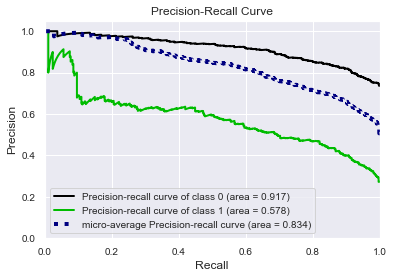

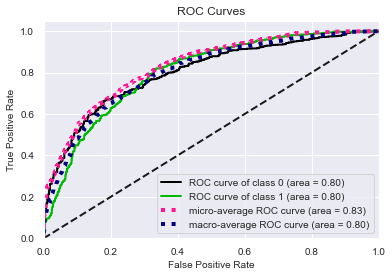

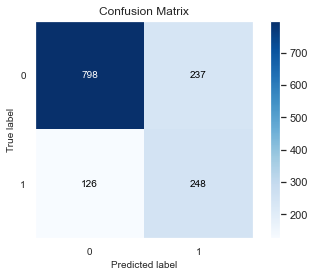

In [25]:
profit = profit(ytest,ypreds)
print(f'Profit = ${profit:,.0f}')
model_eval_bin('xgboost',ytest,ypreds,yprobs2d,show_plots=True)

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [ ]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))